## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution (video presentation) 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

In [10]:
# Data found in https://github.com/dennis-ho/blackjack-simulator, with a small bug fix in the blackjack simulator where the dealer would bust even after player already busted.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


data = pd.read_csv('blackjack_simulator.csv')
data.head()



,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,5,"[4, 5]","[5, 3, 5, 10]",23,"[[4, 5, 6]]",[15],[['D']],0,0,2.0
1,0,409,10,"[10, 11]","[10, 8]",18,"[[10, 11]]",['BJ'],[['S']],5,0,1.5
2,0,405,5,"[10, 10]","[5, 9, 10]",24,"[[10, 10]]",[20],[['S']],2,0,1.0
3,0,400,10,"[10, 11]","[10, 4]",14,"[[10, 11]]",['BJ'],[['S']],0,0,1.5
4,0,396,3,"[10, 10]","[3, 7, 10]",20,"[[10, 10]]",[20],[['S']],-2,0,0.0


### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

In [11]:
# shoe_id = int
# cards_remaining = int
# dealer_up = int
# initial_hand = int array
# dealer_final = int array
# dealer_final_value = int
# player_final = 2d int array
# player_final_value = int array
# actions_taken = 2d string array
# run_count = int
# true_count = int
# win = float

numeric_data = data.select_dtypes(include=['number'])

# Calculate Q1, Q3, and IQR
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR)))

# Count outliers per column
outlier_counts = outliers.sum()
print("Number of outliers per column:")
print(outlier_counts)

# Percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage.apply(lambda x: f"{x:.2f}%")
print("\nPercentage of missing values per column:")
print(missing_percentage)

# print(data.describe())

Number of outliers per column:
shoe_id               0
cards_remaining       0
dealer_up             0
run_count           637
true_count         2442
win                  13
dtype: int64

Percentage of missing values per column:
shoe_id               0.00%
cards_remaining       0.00%
dealer_up             0.00%
initial_hand          0.00%
dealer_final          0.00%
dealer_final_value    0.00%
player_final          0.00%
player_final_value    0.00%
actions_taken         0.00%
run_count             0.00%
true_count            0.00%
win                   0.00%
dtype: object


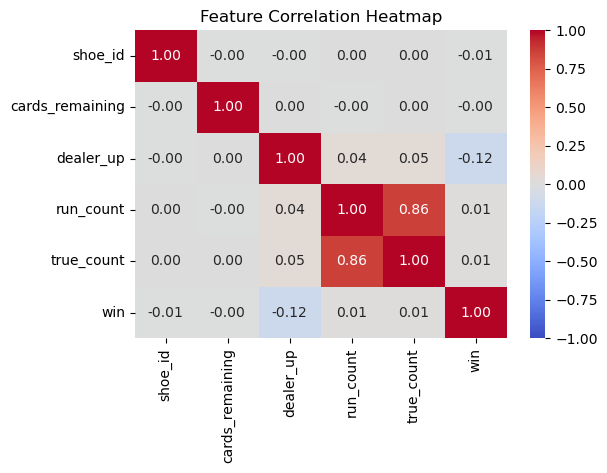

In [12]:
# Correlation between features
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

We found this data in https://github.com/dennis-ho/blackjack-simulator, basically it is a blackjack hands simulator where the player plays by the Basic Strategy Chart.

Our target is the action to take given certain hand, so therefore we don't need most of the features.

With this exploration, we verified that there is no missing values, we expected that because the data is generated.

After meticulously looking at the data, we come up with the features we are interested in. Those being: 

1. dealer_up (the dealer card that the player can see before all his actions)
2. initial_hand (player hand before any action)
3. player_final (cards player had in the end of the play, after the action/s)
5. actions_taken (all the actions the player made)

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

In [13]:
import ast

# Only data we are interested on
data_filtered = data[["dealer_up", "initial_hand", "player_final", "actions_taken"]]

# Make sure the lists are the correct type (some kind of error throws without this)
data_filtered.loc[:, 'initial_hand'] = data_filtered['initial_hand'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_filtered.loc[:, 'player_final'] = data_filtered['player_final'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_filtered.loc[:, 'actions_taken'] = data_filtered['actions_taken'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(data_filtered.head())

   dealer_up initial_hand player_final actions_taken
0          5       [4, 5]  [[4, 5, 6]]         [[D]]
1         10     [10, 11]   [[10, 11]]         [[S]]
2          5     [10, 10]   [[10, 10]]         [[S]]
3         10     [10, 11]   [[10, 11]]         [[S]]
4          3     [10, 10]   [[10, 10]]         [[S]]


In the following code, we are separating the rows into specific hands. We want to train a model to predict the action that should be taken at every card dealt after the initial ones, therefore, we want to train it by steps, so we separated the rows into single actions, for example:

This: 
| dealer_up | initial_hand | player_final | actions_taken |
|:--------:|:--------:|:--------:|:--------:|
|  4   |  [5, 3]   |  [[5, 3, 10]]   |  [[H, S]]   |

Turns into this:
| dealer_up | current_hand | action | current_hand_value |
|:--------:|:--------:|:--------:|:--------:|
|  4   |  [5, 3]   |  H   |  8   |
|  4   |  [5, 3, 10]   |  S   |  18   |

In [14]:
# New DataFrame to store the transformed data
expanded_rows = []

# Function to calculate the hand value with Ace as 11 if possible, otherwise as 1
def calculate_hand_value(hand, hit_or_double=False):
    total = sum(card if card != 11 else 1 for card in hand)  # Start with all Aces as 1
    aces = hand.count(11)  # Count the number of Aces
    while aces > 0 and total + 10 <= 21:
        total += 10  # Upgrade an Ace from 1 to 11
        aces -= 1
    
    # If "Hit" or "Double", check if total goes above 21 and downgrade Ace to 1
    if hit_or_double and total > 21:
        # Recalculate the value with all Aces counted as 1 and then upgrade them if possible
        total = sum(card if card != 11 else 1 for card in hand)  # Recalculate with Ace as 1
        aces = hand.count(11)  # Recalculate number of Aces
        while aces > 0 and total + 10 <= 21:
            total += 10  # Upgrade an Ace from 1 to 11
            aces -= 1

    return total

# Process each row in the DataFrame
for index, row in data_filtered.iterrows():
    hands = [row['initial_hand']]  # Start with the initial hand
    action_groups = row['actions_taken']  # Grouped actions per hand (after splits)
    hand_idx = 0  # Track the index of the current hand in the action_groups

    # Process each hand and its corresponding actions
    while hand_idx < len(action_groups) and hands:
        current_hand = hands.pop(0)  # Take the current hand being processed
        actions = action_groups[hand_idx]  # Get the actions for the current hand

        # Process actions for the current hand
        for action in actions:
            # Calculate current hand value using the soft hand rule
            hit_or_double = action in ['H', 'D']
            hand_value = calculate_hand_value(current_hand, hit_or_double)

            # Ensure hand value doesn't exceed 21 after hit or double
            if hand_value > 21:
                hand_value = sum(card if card != 11 else 1 for card in current_hand)  # Recalculate with Ace as 1

            # Create a row for the current action
            new_row = {
                'dealer_up': row['dealer_up'],
                'current_hand': current_hand.copy(),  # State of the hand before action
                'action': action,
                'current_hand_value': hand_value,  # Always use the adjusted hand value
            }
            expanded_rows.append(new_row)

            # Handle split action (P)
            if action == 'P' and len(current_hand) == 2:
                break  # Stop further actions for the current hand
            elif action in ['H', 'D']:  # Hit or Double
                # Add a card to the current hand for actions like H or D
                next_card = row['player_final'][hand_idx][len(current_hand)]
                current_hand.append(next_card)

        # After handling actions for the current hand, move to the next hand
        if len(hands) > 0:
            hand_idx += 1  # Move to the next hand's actions

# Convert the expanded rows into a new DataFrame
expanded_data = pd.DataFrame(expanded_rows)

# Display the transformed DataFrame and save it to a CSV
expanded_data

,dealer_up,current_hand,action,current_hand_value
0,5,"[4, 5]",D,9
1,10,"[10, 11]",S,21
2,5,"[10, 10]",S,20
3,10,"[10, 11]",S,21
4,3,"[10, 10]",S,20
...,...,...,...,...
69725,4,"[8, 6]",S,14
69726,3,"[10, 10]",S,20
69727,7,"[10, 11]",S,21
69728,8,"[5, 10]",H,15


In [15]:
#calculate the bust probability for the dealers upcard
# odds based on https://www.cachecreek.com/blackjack-odds
def dealer_bust_probability(dealer_upcard):
    bust_probabilities = {
        2: 0.35,
        3: 0.37, 
        4: 0.40,  
        5: 0.42, 
        6: 0.42, 
        7: 0.26,  
        8: 0.24,  
        9: 0.23,  
        10: 0.23, 
        11: 0.17 
    }
    
    return bust_probabilities.get(dealer_upcard) 

#calculate the bust probability for the player
# odds based on https://www.cachecreek.com/blackjack-odds
def player_bust_probability(player_hand_total):
    # Bust probabilities based on the player's hand total
    
    bust_probabilities = {
        21: 1.00,  # if plays asks with 21 its 100% bust 
        20: 0.92,  
        19: 0.85, 
        18: 0.77, 
        17: 0.69, 
        16: 0.62,  
        15: 0.58, 
        14: 0.56,  
        13: 0.39, 
        12: 0.31,
    }
    
    if(player_hand_total<12):
        return 0
    else:
        return bust_probabilities.get(player_hand_total)    
    
     


expanded_data['dealer_bust_probability'] = expanded_data.apply(
    lambda row: dealer_bust_probability(int(row['dealer_up'])), axis=1
)
expanded_data['player_bust_probability'] = expanded_data.apply(
    lambda row: player_bust_probability(int(row['current_hand_value'])), axis=1
)
expanded_data.head()


##count
def calculate_count_adjustment(dealer_card, player_hand, previous_count):
    # Define card value groups
    low_cards = {2, 3, 4, 5, 6}
    high_cards = {10, 11}  # Face cards and Aces
    medium_cards = {7, 8, 9}
    
    count_adjustment = previous_count

    #Dealer, MISSING CARDS
    if dealer_card in low_cards:
        count_adjustment += 1
    elif dealer_card in high_cards:
        count_adjustment -= 1
    elif dealer_card in medium_cards:
        count_adjustment += 0  # No change for medium cards
    
    #Player
    for card in player_hand:
        if card in low_cards:
            count_adjustment += 1
        elif card in high_cards:
            count_adjustment -= 1
        elif card in medium_cards:
            count_adjustment += 0 
            
    return count_adjustment


# Assuming previous_count is initialized to 0 or some starting value
previous_count = 0

# Define a function to apply per row
def apply_count_adjustment(row, previous_count):
    # Call the calculate_count_adjustment function with dealer's hand, player's hand, and the running count
    return calculate_count_adjustment(
        dealer_card=row['dealer_up'],  # Assuming dealer_up is the dealer's single card
        player_hand=row['current_hand'],  # Player's hand as a list
        previous_count=previous_count
    )

# Apply the function to calculate the count adjustment for each row
expanded_data['count_adjustment'] = expanded_data.apply(
    lambda row: apply_count_adjustment(row, previous_count), axis=1
)

def hand_type(hand):
    if 11 in hand and sum(hand) == 21:  # Ace as 11
        return 'BlackJack'
    elif 11 in hand and sum(hand) < 21:  # Ace as 11
        return 'Soft'
    elif hand[0] == hand[1]:  # Pair
        return 'Pair'
    else:
        return 'Hard'

expanded_data['hand_type'] = expanded_data['current_hand'].apply(hand_type)
# Display the updated DataFrame
expanded_data

,dealer_up,current_hand,action,current_hand_value,dealer_bust_probability,player_bust_probability,count_adjustment,hand_type
0,5,"[4, 5]",D,9,0.42,0.00,3,Hard
1,10,"[10, 11]",S,21,0.23,1.00,-3,BlackJack
2,5,"[10, 10]",S,20,0.42,0.92,-1,Pair
3,10,"[10, 11]",S,21,0.23,1.00,-3,BlackJack
4,3,"[10, 10]",S,20,0.37,0.92,-1,Pair
...,...,...,...,...,...,...,...,...
69725,4,"[8, 6]",S,14,0.40,0.56,2,Hard
69726,3,"[10, 10]",S,20,0.37,0.92,-1,Pair
69727,7,"[10, 11]",S,21,0.26,1.00,-2,BlackJack
69728,8,"[5, 10]",H,15,0.24,0.58,0,Hard


### One-hot encode 'actions' and 'hand_type'

In [16]:
action_mapping = {
    'H': 'HIT',
    'S': 'STAND',
    'D': 'DOUBLE_DOWN',
    'P': 'SPLIT',
    'R': 'SURRENDER',
    'I': 'INSURANCE',
    'N': 'NO_INSURANCE'
}

# Map the action codes
expanded_data['action'] = expanded_data['action'].map(action_mapping)

# One-hot encode 'action'
one_hot_encoded = pd.get_dummies(expanded_data['action'], prefix='', prefix_sep='')
one_hot_encoded = one_hot_encoded.astype(int)
expanded_data = pd.concat([expanded_data, one_hot_encoded], axis=1)
expanded_data.drop(columns=['action'], inplace=True)

# Ordinal encode 'hand_type'
hand_type_order = ['Hard', 'Soft', 'Pair', 'BlackJack']
ordinal_encoder = OrdinalEncoder(categories=[hand_type_order])
expanded_data['hand_type'] = ordinal_encoder.fit_transform(expanded_data[['hand_type']]).astype(int)

expanded_data.drop(columns=['count_adjustment'], inplace=True)

# Display the resulting DataFrame
expanded_data

,dealer_up,current_hand,current_hand_value,dealer_bust_probability,player_bust_probability,hand_type,DOUBLE_DOWN,HIT,NO_INSURANCE,SPLIT,STAND,SURRENDER
0,5,"[4, 5]",9,0.42,0.00,0,1,0,0,0,0,0
1,10,"[10, 11]",21,0.23,1.00,3,0,0,0,0,1,0
2,5,"[10, 10]",20,0.42,0.92,2,0,0,0,0,1,0
3,10,"[10, 11]",21,0.23,1.00,3,0,0,0,0,1,0
4,3,"[10, 10]",20,0.37,0.92,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69725,4,"[8, 6]",14,0.40,0.56,0,0,0,0,0,1,0
69726,3,"[10, 10]",20,0.37,0.92,2,0,0,0,0,1,0
69727,7,"[10, 11]",21,0.26,1.00,3,0,0,0,0,1,0
69728,8,"[5, 10]",15,0.24,0.58,0,0,1,0,0,0,0


### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

[0]	validation_0-mlogloss:1.12171
[1]	validation_0-mlogloss:0.83211
[2]	validation_0-mlogloss:0.65204
[3]	validation_0-mlogloss:0.52975
[4]	validation_0-mlogloss:0.44239
[5]	validation_0-mlogloss:0.37862
[6]	validation_0-mlogloss:0.33212
[7]	validation_0-mlogloss:0.29714
[8]	validation_0-mlogloss:0.27134
[9]	validation_0-mlogloss:0.25162
[10]	validation_0-mlogloss:0.23663
[11]	validation_0-mlogloss:0.22522
[12]	validation_0-mlogloss:0.21651
[13]	validation_0-mlogloss:0.20954
[14]	validation_0-mlogloss:0.20387
[15]	validation_0-mlogloss:0.19935
[16]	validation_0-mlogloss:0.19589
[17]	validation_0-mlogloss:0.19312
[18]	validation_0-mlogloss:0.19076
[19]	validation_0-mlogloss:0.18884
[20]	validation_0-mlogloss:0.18725
[21]	validation_0-mlogloss:0.18553
[22]	validation_0-mlogloss:0.18433
[23]	validation_0-mlogloss:0.18338
[24]	validation_0-mlogloss:0.18240
[25]	validation_0-mlogloss:0.18163
[26]	validation_0-mlogloss:0.18100
[27]	validation_0-mlogloss:0.18044
[28]	validation_0-mlogloss:0.1

c:\Users\Bruger\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6789 - loss: 0.9445 - val_accuracy: 0.7294 - val_loss: 0.7041
Epoch 2/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7343 - loss: 0.6655 - val_accuracy: 0.7453 - val_loss: 0.6157
Epoch 3/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7535 - loss: 0.5838 - val_accuracy: 0.7633 - val_loss: 0.5194
Epoch 4/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7885 - loss: 0.5032 - val_accuracy: 0.8185 - val_loss: 0.4649
Epoch 5/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8153 - loss: 0.4379 - val_accuracy: 0.8290 - val_loss: 0.3889
Epoch 6/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8329 - loss: 0.3885 - val_accuracy: 0.8583 - val_loss: 0.3378
Epoch 7/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8507 - loss: 0.3471 - val_accuracy: 0.8469 - val_loss: 0.3565
Epoch 8/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8594 - loss: 0.3247 - val_accuracy: 0.8588

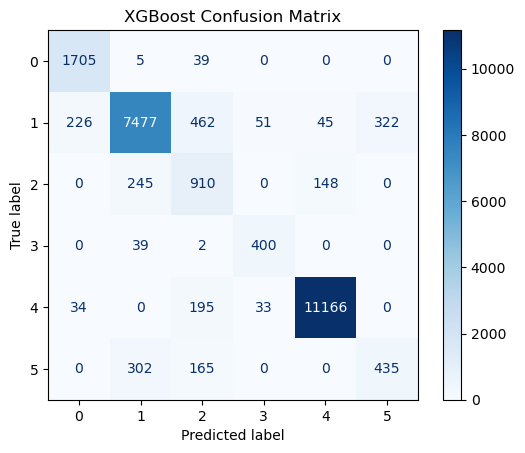

Feedforward Neural Network Accuracy: 0.9034


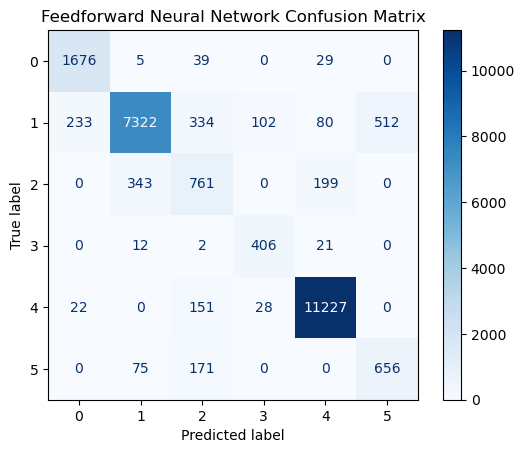

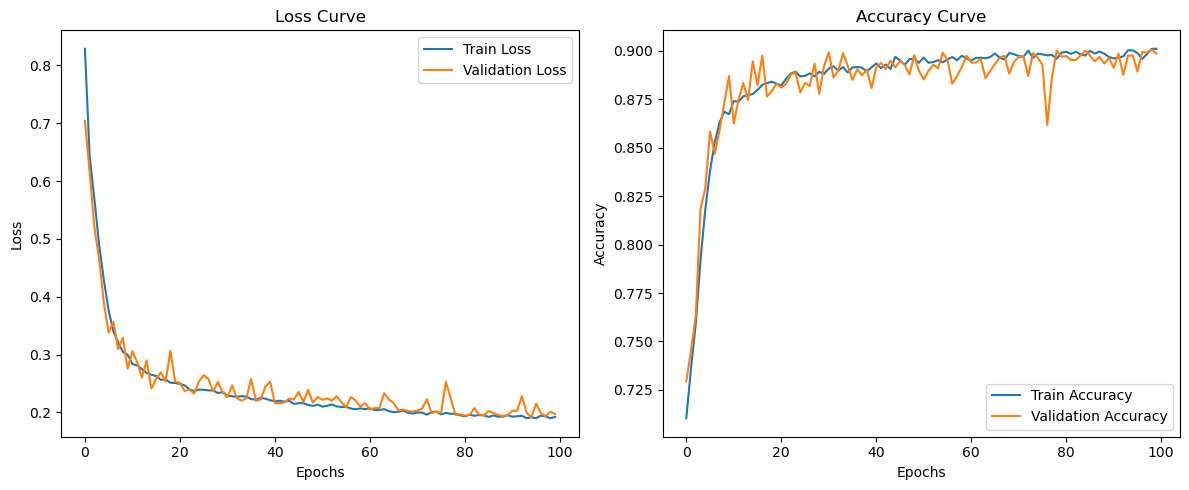

In [ ]:
X = expanded_data.drop(columns=['DOUBLE_DOWN', 'HIT', 'NO_INSURANCE', 'SPLIT', 'STAND', 'SURRENDER', 'current_hand'])
y = expanded_data[['DOUBLE_DOWN', 'HIT', 'NO_INSURANCE', 'SPLIT', 'STAND', 'SURRENDER']]

y = y.idxmax(axis=1).astype('category').cat.codes

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === XGBoost ===
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predictions
xgb_preds = xgb_clf.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

# === Feedforward Neural Network ===
# Convert y to categorical for neural network
y_train_nn = to_categorical(y_train, num_classes=6)
y_val_nn = to_categorical(y_val, num_classes=6)
y_test_nn = to_categorical(y_test, num_classes=6)

# Define the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_nn, 
                    epochs=100, 
                    validation_data=(X_val, y_val_nn), 
                    verbose=1)

# Predictions
nn_preds = model.predict(X_test)
nn_preds = np.argmax(nn_preds, axis=1)

print("Feedforward Neural Network Classification Report:")
print(classification_report(y_test, nn_preds))

# Accuracy Score
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_clf.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

nn_accuracy = accuracy_score(y_test, nn_preds)
print(f"Feedforward Neural Network Accuracy: {nn_accuracy:.4f}")

# Confusion Matrix
nn_cm = confusion_matrix(y_test, nn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Feedforward Neural Network Confusion Matrix")
plt.show()

# Training Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.